**import library**

In [77]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

import scipy.stats as stats
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

**Load Data**

In [2]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

# Summary Stats

**sum_gamerounds**

In [7]:
df.groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0000,52.4563,256.7164,0.0000,5.0000,17.0000,50.0000,49854.0000
gate_40,45489.0000,51.2988,103.2944,0.0000,5.0000,16.0000,52.0000,2640.0000


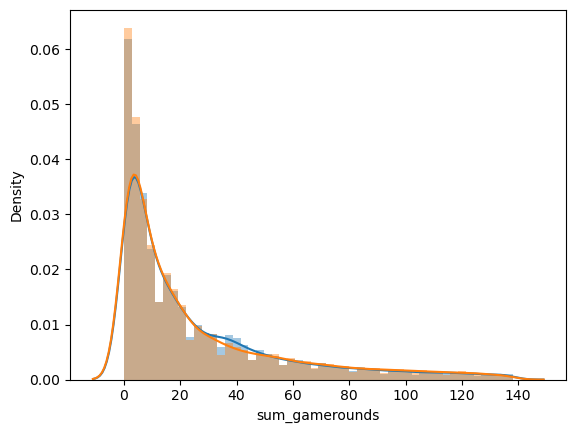

In [40]:
# 計算IQR
Q1 = df['sum_gamerounds'].quantile(q=0.25)
Q3 = df['sum_gamerounds'].quantile(q=0.75)
IQR = Q3 - Q1

# 排除outlier的distribution
sns.distplot(df[(df['version'] == 'gate_30') & (df['sum_gamerounds'] <= 3*IQR)]['sum_gamerounds'])
sns.distplot(df[(df['version'] == 'gate_40') & (df['sum_gamerounds'] <= 3*IQR)]['sum_gamerounds'])

plt.show()

觀察兩組使用者的"sum_gamerounds"，可以發現平均而言gate_40的使用者的平均遊玩次數較高一些。

In [23]:
df[df['retention_1'] == True].groupby('version')['retention_1'].count()

version
gate_30    20034
gate_40    20119
Name: retention_1, dtype: int64

觀察兩組使用者在一天後重新登入遊戲的人數，發現 “gate_40” 稍微多出一些。

In [24]:
df[df['retention_7'] == True].groupby('version')['retention_7'].count()

version
gate_30    8502
gate_40    8279
Name: retention_7, dtype: int64

觀察兩組使用者在七天後重新登入遊戲的人數，發現 “gate_30” 反而稍微多出一些。

# Remove outliers

由於我們往後的檢定將會使用mean來進行測量，而mean最大的缺點之一便是容易受到極段值影響，因此我們應改先剔除資料中德極端值。

IQR : 46.0


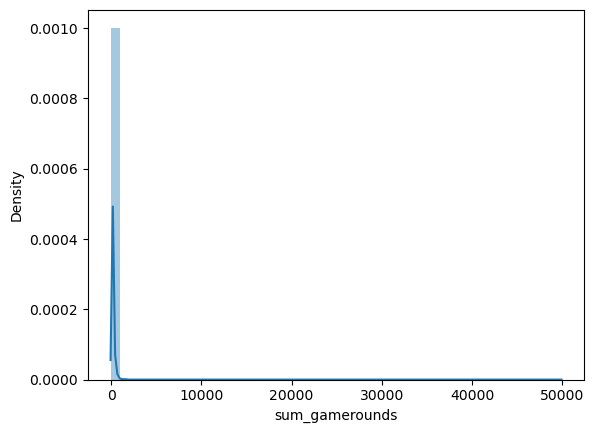

In [38]:
# 計算IQR
Q1 = df['sum_gamerounds'].quantile(q=0.25)
Q3 = df['sum_gamerounds'].quantile(q=0.75)
IQR = Q3 - Q1
print(f"IQR : {IQR}")

# 機率分配圖
sns.distplot(df['sum_gamerounds'])
plt.show()

In [36]:
df = df[df['sum_gamerounds'] < 3 * IQR]

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
3,483,gate_40,1,False,False
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


以傳統3倍IQR當作是oulier 的 threadhold並將outlier剔除

# Other Details 

**retension & sum_gamerounds**

In [45]:
df.groupby(['version', 'retention_1']).sum_gamerounds.agg(['count', 'median', 'mean', 'std'])

count  median    mean      std
version retention_1                                
gate_30 False        24666  6.0000 18.3796 319.4232
        True         20034 48.0000 94.4117 135.0377
gate_40 False        25370  6.0000 16.3404  35.9258
        True         20119 49.0000 95.3812 137.8873

In [47]:
df.groupby(['version', 'retention_7']).sum_gamerounds.agg(['count', 'median', 'mean', 'std'])

count   median     mean      std
version retention_7                                  
gate_30 False        36198  11.0000  25.7965  43.3162
        True          8502 105.0000 165.9625 568.0006
gate_40 False        37210  11.0000  25.8564  44.4061
        True          8279 111.0000 165.6498 183.7925

我們可以由上表發現，“gate_40”的玩家在第二天重新登入遊戲與否，造成在遊玩回合上的差異大於“gate_30”的玩家

**持續性玩家**

In [52]:
df['Retention'] = np.where((df.retention_1 == True) & (df.retention_7 == True), 1,0)
df.groupby('version')['Retention'].sum()

version
gate_30    6676
gate_40    6506
Name: Retention, dtype: int64

“gate_30”相較於“gate_40”中出現了更多的持續性玩家。

**流失玩家**

In [53]:
df['Loss'] = np.where((df.retention_1 == True) & (df.retention_7 == False), 1,0)
df.groupby('version')['Loss'].sum()

version
gate_30    13358
gate_40    13613
Name: Loss, dtype: int64

“gate_40”相較於“gate_30”中出現了更多的流失玩家。

**回鍋玩家**

In [54]:
df['Return'] = np.where((df.retention_1 == False) & (df.retention_7 == True), 1,0)
df.groupby('version')['Return'].sum()

version
gate_30    1826
gate_40    1773
Name: Return, dtype: int64

“gate_40”相較於“gate_30”中出現了更多的回鍋玩家。

# A/B Testing

**Check normality**

In [55]:
df["version"] = np.where(df.version == "gate_30", "A", "B")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,Loss,Return
0,116,A,3,False,False,0,0,0
1,337,A,38,True,False,0,1,0
2,377,B,165,True,False,0,1,0
3,483,B,1,False,False,0,0,0
4,488,B,179,True,True,1,0,0


**AB testing function**

In [76]:
def AB_Test(dataframe, group, target):
    
    # Split A/B
    groupA = dataframe.loc[dataframe[group] == "A", target]
    groupB = dataframe.loc[dataframe[group] == "B", target]
    
    # 檢驗 AB 兩組受試者是否為常態分佈
    # H0: Distribution is Normal
    # H1: Distribution is not Normal
    
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    
    # 檢定變異數同質性
    # H0: Homogeneity: False
    # H1: Heterogeneous: True
    leveneTest = None
    
    if not ntA and not ntB:
        leveneTest = levene(groupA, groupB)[1] < 0.05 
        ttest_func = ttest_ind
        if leveneTest:
            ttest_func = lambda a, b: ttest_ind(a, b, equal_var=False)[1]
    else:
        ttest_func = mannwhitneyu
        
    # 假設檢定
    ttest = ttest_func(groupA, groupB)[1]
    
    # 結果
    homogeneity = "Yes" if not leveneTest else "No"
    hypothesis_result = "Reject H0" if ttest < 0.05 else "Fail to Reject H0"
    comment = "A/B groups are not similar!" if hypothesis_result == "Reject H0" else "A/B groups are similar!"
    
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    print('-'*50)
    print(f"Test Type: {'Parametric' if not ntA and not ntB else 'Non-Parametric'}")
    print(f"Homogeneity: {homogeneity}")
    print(f"AB Hypothesis: {hypothesis_result}")
    print(f"p-value: {ttest}")
    print(f"Comment: {comment}")
    print('-'*50)

**sum_gamerounds**

In [75]:
AB_Test(dataframe=df, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 

--------------------------------------------------
Test Type: Non-Parametric
Homogeneity: Yes
AB Hypothesis: Fail to Reject H0
p-value: 0.05020880772044255
Comment: A/B groups are similar!
--------------------------------------------------


由以上假設檢定結果可知，雖然gate_40的玩家遊玩次數較多餘gate_30的玩家，但並未在統計上顯著。